In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [4]:
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model and move to device
model = SimpleANN().to(device)
print(model)

SimpleANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [5]:
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=1.0, bias=True):
        super().__init__()
        self.r = r
        self.alpha = alpha
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        # LoRA parameters
        if r > 0:
            self.A = nn.Parameter(torch.zeros(r, in_features))
            self.B = nn.Parameter(torch.zeros(out_features, r))
            # Initialization as in the LoRA paper
            nn.init.kaiming_uniform_(self.A, a=np.sqrt(5))
            nn.init.zeros_(self.B)
            self.scaling = self.alpha / self.r
        else:
            self.A = None
            self.B = None
            self.scaling = 0

        # Freeze the original linear weights
        for param in self.linear.parameters():
            param.requires_grad = False

    def forward(self, x):
        result = self.linear(x)
        if self.r > 0:
            lora_update = (x @ self.A.t()) @ self.B.t() * self.scaling
            result = result + lora_update
        return result

In [6]:
class LoRA_ANN(nn.Module):
    def __init__(self, r=4, alpha=1.0):
        super(LoRA_ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = LoRALinear(28*28, 256, r=r, alpha=alpha)
        self.fc2 = LoRALinear(256, 128, r=r, alpha=alpha)
        self.fc3 = LoRALinear(128, 10, r=r, alpha=alpha)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the LoRA model and move to device
lora_model = LoRA_ANN(r=4, alpha=1.0).to(device)
print(lora_model)

LoRA_ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LoRALinear(
    (linear): Linear(in_features=784, out_features=256, bias=True)
  )
  (fc2): LoRALinear(
    (linear): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc3): LoRALinear(
    (linear): Linear(in_features=128, out_features=10, bias=True)
  )
  (relu): ReLU()
)


In [7]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [8]:
# Only LoRA parameters are trainable
lora_params = [p for p in lora_model.parameters() if p.requires_grad]
print(f"Number of trainable parameters: {sum(p.numel() for p in lora_params)}")

optimizer = optim.Adam(lora_params, lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_one_epoch(lora_model, train_loader, optimizer, criterion, device)
    test_acc = evaluate(lora_model, test_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Number of trainable parameters: 6248
Epoch 1/5 | Train Loss: 0.9875 | Test Accuracy: 0.8292
Epoch 2/5 | Train Loss: 0.5089 | Test Accuracy: 0.8610
Epoch 3/5 | Train Loss: 0.4344 | Test Accuracy: 0.8758
Epoch 4/5 | Train Loss: 0.3751 | Test Accuracy: 0.8932
Epoch 5/5 | Train Loss: 0.3357 | Test Accuracy: 0.9015


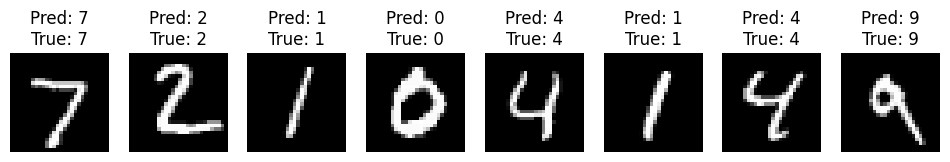

In [9]:
# Visualize a few test images and predictions
def plot_predictions(model, dataloader, device, num_images=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    images = images.cpu().numpy()
    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        plt.axis('off')
    plt.show()

plot_predictions(lora_model, test_loader, device)

In [10]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters in LoRA model:", count_trainable_params(lora_model))
print("Trainable parameters in standard ANN:", count_trainable_params(model))

Trainable parameters in LoRA model: 6248
Trainable parameters in standard ANN: 235146


In [11]:
def train_and_evaluate_lora(r, alpha, num_epochs=3):
    model = LoRA_ANN(r=r, alpha=alpha).to(device)
    lora_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(lora_params, lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        test_acc = evaluate(model, test_loader, device)
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
    n_params = sum(p.numel() for p in lora_params)
    return {
        'r': r,
        'alpha': alpha,
        'params': n_params,
        'final_acc': history['test_acc'][-1],
        'history': history
    }

In [12]:
results = []
r_values = [1, 2, 4, 8, 16]
alpha_values = [1.0, 2.0, 4.0, 8.0]

for r in r_values:
    for alpha in alpha_values:
        print(f"Training LoRA model with r={r}, alpha={alpha}...")
        result = train_and_evaluate_lora(r, alpha, num_epochs=3)
        results.append(result)
        print(f"  Params: {result['params']}, Final Test Acc: {result['final_acc']:.4f}")

Training LoRA model with r=1, alpha=1.0...
  Params: 1562, Final Test Acc: 0.6537
Training LoRA model with r=1, alpha=2.0...
  Params: 1562, Final Test Acc: 0.6920
Training LoRA model with r=1, alpha=4.0...
  Params: 1562, Final Test Acc: 0.6899
Training LoRA model with r=1, alpha=8.0...
  Params: 1562, Final Test Acc: 0.7271
Training LoRA model with r=2, alpha=1.0...
  Params: 3124, Final Test Acc: 0.8382
Training LoRA model with r=2, alpha=2.0...
  Params: 3124, Final Test Acc: 0.8467
Training LoRA model with r=2, alpha=4.0...
  Params: 3124, Final Test Acc: 0.8624
Training LoRA model with r=2, alpha=8.0...
  Params: 3124, Final Test Acc: 0.8507
Training LoRA model with r=4, alpha=1.0...
  Params: 6248, Final Test Acc: 0.8764
Training LoRA model with r=4, alpha=2.0...
  Params: 6248, Final Test Acc: 0.8974
Training LoRA model with r=4, alpha=4.0...
  Params: 6248, Final Test Acc: 0.9030
Training LoRA model with r=4, alpha=8.0...
  Params: 6248, Final Test Acc: 0.9059
Training LoRA mo

In [13]:
print("Summary of LoRA experiments:")
print(" r | alpha | params | final_acc ")
print("---|-------|--------|-----------")
for res in results:
    print(f"{res['r']:2d} | {res['alpha']:5.1f} | {res['params']:6d} | {res['final_acc']:.4f}")

Summary of LoRA experiments:
 r | alpha | params | final_acc 
---|-------|--------|-----------
 1 |   1.0 |   1562 | 0.6537
 1 |   2.0 |   1562 | 0.6920
 1 |   4.0 |   1562 | 0.6899
 1 |   8.0 |   1562 | 0.7271
 2 |   1.0 |   3124 | 0.8382
 2 |   2.0 |   3124 | 0.8467
 2 |   4.0 |   3124 | 0.8624
 2 |   8.0 |   3124 | 0.8507
 4 |   1.0 |   6248 | 0.8764
 4 |   2.0 |   6248 | 0.8974
 4 |   4.0 |   6248 | 0.9030
 4 |   8.0 |   6248 | 0.9059
 8 |   1.0 |  12496 | 0.9148
 8 |   2.0 |  12496 | 0.9242
 8 |   4.0 |  12496 | 0.9341
 8 |   8.0 |  12496 | 0.9424
16 |   1.0 |  24992 | 0.9178
16 |   2.0 |  24992 | 0.9324
16 |   4.0 |  24992 | 0.9381
16 |   8.0 |  24992 | 0.9488


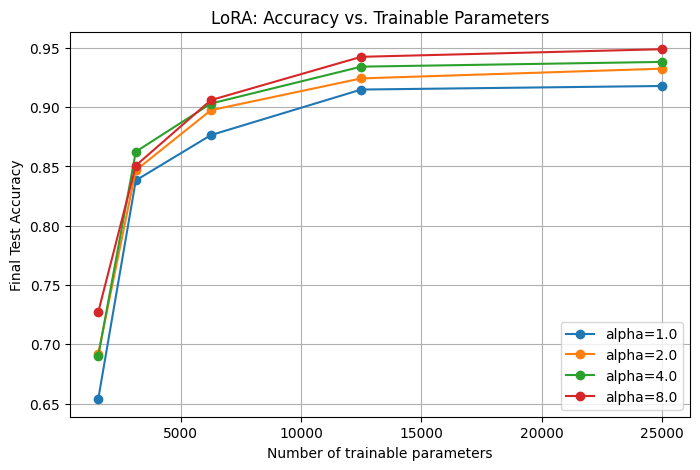

In [14]:
import pandas as pd

df = pd.DataFrame(results)
plt.figure(figsize=(8,5))
for alpha in alpha_values:
    subset = df[df['alpha'] == alpha]
    plt.plot(subset['params'], subset['final_acc'], marker='o', label=f'alpha={alpha}')
plt.xlabel('Number of trainable parameters')
plt.ylabel('Final Test Accuracy')
plt.title('LoRA: Accuracy vs. Trainable Parameters')
plt.legend()
plt.grid(True)
plt.show()